In [1]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data/ashok_mar19_mar20.csv',index_col=0)
# dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['AT','BP','PM10','Benzene','Toluene','NH3','NO','NO2','NOx','RH','SR','WS','WD','Ozone','SO2','CO','PM2.5']
dataset.index.name = 'Date'
# mark all NA values with 0
dataset['PM2.5'].fillna(0, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')


/home/rishotics/anaconda3/envs/rl3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


                     AT      BP    PM10  Benzene  Toluene     NH3    NO   NO2  \
Date                                                                            
19-03-2019 00:00  23.11  986.47  222.69    53.77   176.33  149.05  0.63  7.77   
20-03-2019 00:00  25.82  984.78  223.62    47.16   149.60  130.92  0.67  7.92   
21-03-2019 00:00  24.86  988.30  178.79    50.40   164.93  116.82  0.84  6.56   
22-03-2019 00:00  23.95  990.27  126.25    40.88   188.77  208.38  0.43  2.36   
23-03-2019 00:00  24.03  989.49  148.54    44.30   181.58  197.88  0.66  2.39   

                    NOx     RH     SR     WS     WD  Ozone    SO2    CO  \
Date                                                                      
19-03-2019 00:00  33.77  27.21  48.00  77.84  80.51  42.99  31.07  1.55   
20-03-2019 00:00  24.46  30.84  23.99  59.80  51.34  49.98  23.85  1.45   
21-03-2019 00:00   9.08  36.49   3.68  32.57  19.23  55.16  25.41  1.22   
22-03-2019 00:00   6.75  27.38   2.53  40.06  22.83  56.4

(367, 17)


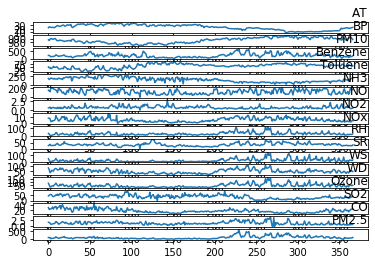

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

print(values.shape)
# specify columns to plot
groups=[]
for i in range(values.shape[1]):
    groups.append(i)
# groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,]
# print(groups)
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
#     print(group)
    pyplot.title(dataset.columns[group], y=1, loc='right')
    i += 1
# pyplot.plot(values[:,0])
# #     print(group)
# pyplot.title(dataset.columns[2], y=0.5, loc='right')
# pyplot.show()
# # values[:,0]

In [3]:
from numpy import array
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

n_hours=1
n_out= 1
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
print(values.shape)
scaled = scaler.fit_transform(values)
print(len(scaled))
X, y = split_sequences(scaled, n_hours, n_out)
# for i in range(0,1):
#     print(X[i], y[i])
print(X.shape,y.shape)

(367, 17)
367
(367, 1, 16) (367, 1)


In [14]:
# yhat11 = model.predict(test_X, verbose=0)
# pyplot.figure()
# pyplot.plot(yhat11[:])
# pyplot.plot(test_y[:])
# pyplot.show()
# print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(np.sum((((yhat11-test_y)**2)))))

def MODEL(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=2, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(np.sum((((yhat11-test_y)**2)))))
    return(np.sqrt(np.sum((((yhat11-test_y)**2)))))
def main(n_out_max,n_hour_max):
    dataset = read_csv('pollution.csv', header=0, index_col=0)
    values = dataset.values
    # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
    values = values.astype('float32')
# normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    print(values.shape)
    scaled = scaler.fit_transform(values)
    print(len(scaled))
    result=np.zeros((n_out_max,n_out_max),dtype=np.float32)
    for n_out in range (1,n_out_max+1):
        for n_hours in range(1,n_hour_max+1):
            X, y = split_sequences(scaled, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
            result[n_out-1,n_hours-1]=error
      
    return result
            
            
            
            
n_out_max,n_hour_max= 5,5
r=main(n_out_max,n_hour_max)


(367, 17)
367
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 1, 16) (300, 1) (37, 1, 16) (37, 1)
val X, val y (30, 1, 16) (30, 1)
Train on 300 samples, validate on 30 samples
Epoch 1/200
 - 4s - loss: 0.0506 - val_loss: 0.0514
Epoch 2/200
 - 0s - loss: 0.0310 - val_loss: 0.0232
Epoch 3/200
 - 0s - loss: 0.0227 - val_loss: 0.0100
Epoch 4/200
 - 0s - loss: 0.0218 - val_loss: 0.0070
Epoch 5/200
 - 0s - loss: 0.0182 - val_loss: 0.0050
Epoch 6/200
 - 0s - loss: 0.0141 - val_loss: 0.0031
Epoch 7/200
 - 0s - loss: 0.0104 - val_loss: 0.0021
Epoch 8/200
 - 0s - loss: 0.0076 - val_loss: 0.0024
Epoch 9/200
 - 0s - loss: 0.0061 - val_loss: 0.0030
Epoch 10/200
 - 0s - loss: 0.0056 - val_loss: 0.0033
Epoch 11/200
 - 0s - loss: 0.0053 - val_loss: 0.0030
Epoch 12/200
 - 0s - loss: 0.0049 - val_loss: 0.0030
Epoch 13/200
 - 0s - loss: 0.0046 - val_loss: 0.0028
Epoch 14/200
 - 0s - loss: 0.0043 - val_loss: 0.0027
Epoch 15/200
 - 0s - loss: 0.0040 - val_loss: 0.0026
Epoch 16/200
 - 0s - l

 - 0s - loss: 0.0014 - val_loss: 0.0021
Epoch 148/200
 - 0s - loss: 0.0017 - val_loss: 5.5924e-04
Epoch 149/200
 - 0s - loss: 0.0014 - val_loss: 0.0020
Epoch 150/200
 - 0s - loss: 0.0016 - val_loss: 5.6198e-04
Epoch 151/200
 - 0s - loss: 0.0014 - val_loss: 0.0020
Epoch 152/200
 - 0s - loss: 0.0016 - val_loss: 5.7809e-04
Epoch 153/200
 - 0s - loss: 0.0014 - val_loss: 0.0020
Epoch 154/200
 - 0s - loss: 0.0016 - val_loss: 5.7264e-04
Epoch 155/200
 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 156/200
 - 0s - loss: 0.0016 - val_loss: 5.8350e-04
Epoch 157/200
 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 158/200
 - 0s - loss: 0.0016 - val_loss: 5.8137e-04
Epoch 159/200
 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 160/200
 - 0s - loss: 0.0016 - val_loss: 5.9705e-04
Epoch 161/200
 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 162/200
 - 0s - loss: 0.0016 - val_loss: 5.9262e-04
Epoch 163/200
 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 164/200
 - 0s - loss: 0.0015 - val_loss: 5.9560e-04
Epoch 

Epoch 93/200
 - 0s - loss: 0.0047 - val_loss: 0.0049
Epoch 94/200
 - 0s - loss: 0.0059 - val_loss: 0.0010
Epoch 95/200
 - 0s - loss: 0.0034 - val_loss: 0.0015
Epoch 96/200
 - 0s - loss: 0.0073 - val_loss: 0.0015
Epoch 97/200
 - 0s - loss: 0.0043 - val_loss: 0.0039
Epoch 98/200
 - 0s - loss: 0.0066 - val_loss: 0.0014
Epoch 99/200
 - 0s - loss: 0.0028 - val_loss: 0.0028
Epoch 100/200
 - 0s - loss: 0.0041 - val_loss: 7.0477e-04
Epoch 101/200
 - 0s - loss: 0.0029 - val_loss: 0.0020
Epoch 102/200
 - 0s - loss: 0.0053 - val_loss: 0.0011
Epoch 103/200
 - 0s - loss: 0.0029 - val_loss: 0.0029
Epoch 104/200
 - 0s - loss: 0.0042 - val_loss: 8.8808e-04
Epoch 105/200
 - 0s - loss: 0.0023 - val_loss: 0.0021
Epoch 106/200
 - 0s - loss: 0.0035 - val_loss: 6.9599e-04
Epoch 107/200
 - 0s - loss: 0.0026 - val_loss: 0.0020
Epoch 108/200
 - 0s - loss: 0.0045 - val_loss: 0.0011
Epoch 109/200
 - 0s - loss: 0.0023 - val_loss: 0.0022
Epoch 110/200
 - 0s - loss: 0.0033 - val_loss: 7.1169e-04
Epoch 111/200
 - 0s

Epoch 38/200
 - 0s - loss: 0.0047 - val_loss: 0.0080
Epoch 39/200
 - 0s - loss: 0.0062 - val_loss: 0.0035
Epoch 40/200
 - 0s - loss: 0.0048 - val_loss: 0.0079
Epoch 41/200
 - 0s - loss: 0.0064 - val_loss: 0.0032
Epoch 42/200
 - 0s - loss: 0.0046 - val_loss: 0.0077
Epoch 43/200
 - 0s - loss: 0.0060 - val_loss: 0.0030
Epoch 44/200
 - 0s - loss: 0.0044 - val_loss: 0.0074
Epoch 45/200
 - 0s - loss: 0.0057 - val_loss: 0.0028
Epoch 46/200
 - 0s - loss: 0.0042 - val_loss: 0.0069
Epoch 47/200
 - 0s - loss: 0.0055 - val_loss: 0.0026
Epoch 48/200
 - 0s - loss: 0.0042 - val_loss: 0.0066
Epoch 49/200
 - 0s - loss: 0.0057 - val_loss: 0.0023
Epoch 50/200
 - 0s - loss: 0.0040 - val_loss: 0.0062
Epoch 51/200
 - 0s - loss: 0.0053 - val_loss: 0.0021
Epoch 52/200
 - 0s - loss: 0.0039 - val_loss: 0.0062
Epoch 53/200
 - 0s - loss: 0.0053 - val_loss: 0.0019
Epoch 54/200
 - 0s - loss: 0.0037 - val_loss: 0.0056
Epoch 55/200
 - 0s - loss: 0.0049 - val_loss: 0.0018
Epoch 56/200
 - 0s - loss: 0.0036 - val_loss: 

Epoch 187/200
 - 0s - loss: 0.0015 - val_loss: 4.8260e-04
Epoch 188/200
 - 0s - loss: 0.0011 - val_loss: 8.4808e-04
Epoch 189/200
 - 0s - loss: 0.0014 - val_loss: 4.8163e-04
Epoch 190/200
 - 0s - loss: 0.0012 - val_loss: 8.3977e-04
Epoch 191/200
 - 0s - loss: 0.0015 - val_loss: 4.9585e-04
Epoch 192/200
 - 0s - loss: 0.0012 - val_loss: 8.8874e-04
Epoch 193/200
 - 0s - loss: 0.0015 - val_loss: 4.8194e-04
Epoch 194/200
 - 0s - loss: 0.0011 - val_loss: 8.2557e-04
Epoch 195/200
 - 0s - loss: 0.0014 - val_loss: 4.8974e-04
Epoch 196/200
 - 0s - loss: 0.0011 - val_loss: 7.6951e-04
Epoch 197/200
 - 0s - loss: 0.0015 - val_loss: 4.9000e-04
Epoch 198/200
 - 0s - loss: 0.0011 - val_loss: 7.9831e-04
Epoch 199/200
 - 0s - loss: 0.0014 - val_loss: 5.0490e-04
Epoch 200/200
 - 0s - loss: 0.0011 - val_loss: 7.9421e-04
RMSE error using  3  state size to predict  1  step is = 0.2460233
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 4, 16) (300, 1) (34, 4, 16) (34, 1)
val X, val y (30, 4, 

Epoch 133/200
 - 0s - loss: 0.0018 - val_loss: 0.0013
Epoch 134/200
 - 0s - loss: 0.0023 - val_loss: 4.7063e-04
Epoch 135/200
 - 0s - loss: 0.0018 - val_loss: 0.0013
Epoch 136/200
 - 0s - loss: 0.0024 - val_loss: 4.7137e-04
Epoch 137/200
 - 0s - loss: 0.0018 - val_loss: 0.0013
Epoch 138/200
 - 0s - loss: 0.0023 - val_loss: 4.6798e-04
Epoch 139/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 140/200
 - 0s - loss: 0.0024 - val_loss: 4.7851e-04
Epoch 141/200
 - 0s - loss: 0.0018 - val_loss: 0.0013
Epoch 142/200
 - 0s - loss: 0.0022 - val_loss: 4.7714e-04
Epoch 143/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 144/200
 - 0s - loss: 0.0022 - val_loss: 4.6774e-04
Epoch 145/200
 - 0s - loss: 0.0017 - val_loss: 0.0012
Epoch 146/200
 - 0s - loss: 0.0021 - val_loss: 4.6953e-04
Epoch 147/200
 - 0s - loss: 0.0018 - val_loss: 0.0012
Epoch 148/200
 - 0s - loss: 0.0023 - val_loss: 4.8661e-04
Epoch 149/200
 - 0s - loss: 0.0018 - val_loss: 0.0011
Epoch 150/200
 - 0s - loss: 0.0023 - val_loss: 4.8

Epoch 78/200
 - 0s - loss: 0.0027 - val_loss: 0.0018
Epoch 79/200
 - 0s - loss: 0.0034 - val_loss: 7.5910e-04
Epoch 80/200
 - 0s - loss: 0.0026 - val_loss: 0.0016
Epoch 81/200
 - 0s - loss: 0.0034 - val_loss: 7.2047e-04
Epoch 82/200
 - 0s - loss: 0.0026 - val_loss: 0.0016
Epoch 83/200
 - 0s - loss: 0.0033 - val_loss: 7.2207e-04
Epoch 84/200
 - 0s - loss: 0.0025 - val_loss: 0.0015
Epoch 85/200
 - 0s - loss: 0.0032 - val_loss: 7.0186e-04
Epoch 86/200
 - 0s - loss: 0.0025 - val_loss: 0.0015
Epoch 87/200
 - 0s - loss: 0.0032 - val_loss: 7.1617e-04
Epoch 88/200
 - 0s - loss: 0.0024 - val_loss: 0.0014
Epoch 89/200
 - 0s - loss: 0.0032 - val_loss: 6.9701e-04
Epoch 90/200
 - 0s - loss: 0.0024 - val_loss: 0.0014
Epoch 91/200
 - 0s - loss: 0.0031 - val_loss: 7.0410e-04
Epoch 92/200
 - 0s - loss: 0.0023 - val_loss: 0.0013
Epoch 93/200
 - 0s - loss: 0.0030 - val_loss: 6.9136e-04
Epoch 94/200
 - 0s - loss: 0.0023 - val_loss: 0.0014
Epoch 95/200
 - 0s - loss: 0.0030 - val_loss: 7.0396e-04
Epoch 96/2

 - 0s - loss: 0.0043 - val_loss: 0.0054
Epoch 21/200
 - 0s - loss: 0.0041 - val_loss: 0.0053
Epoch 22/200
 - 0s - loss: 0.0040 - val_loss: 0.0053
Epoch 23/200
 - 0s - loss: 0.0038 - val_loss: 0.0052
Epoch 24/200
 - 0s - loss: 0.0037 - val_loss: 0.0051
Epoch 25/200
 - 0s - loss: 0.0036 - val_loss: 0.0051
Epoch 26/200
 - 0s - loss: 0.0035 - val_loss: 0.0050
Epoch 27/200
 - 0s - loss: 0.0034 - val_loss: 0.0049
Epoch 28/200
 - 0s - loss: 0.0033 - val_loss: 0.0049
Epoch 29/200
 - 0s - loss: 0.0033 - val_loss: 0.0049
Epoch 30/200
 - 0s - loss: 0.0032 - val_loss: 0.0048
Epoch 31/200
 - 0s - loss: 0.0032 - val_loss: 0.0048
Epoch 32/200
 - 0s - loss: 0.0032 - val_loss: 0.0048
Epoch 33/200
 - 0s - loss: 0.0031 - val_loss: 0.0048
Epoch 34/200
 - 0s - loss: 0.0031 - val_loss: 0.0048
Epoch 35/200
 - 0s - loss: 0.0031 - val_loss: 0.0048
Epoch 36/200
 - 0s - loss: 0.0030 - val_loss: 0.0047
Epoch 37/200
 - 0s - loss: 0.0030 - val_loss: 0.0048
Epoch 38/200
 - 0s - loss: 0.0030 - val_loss: 0.0049
Epoch 

Epoch 174/200
 - 0s - loss: 0.0028 - val_loss: 0.0105
Epoch 175/200
 - 0s - loss: 0.0032 - val_loss: 0.0058
Epoch 176/200
 - 0s - loss: 0.0029 - val_loss: 0.0104
Epoch 177/200
 - 0s - loss: 0.0036 - val_loss: 0.0046
Epoch 178/200
 - 0s - loss: 0.0032 - val_loss: 0.0107
Epoch 179/200
 - 0s - loss: 0.0030 - val_loss: 0.0043
Epoch 180/200
 - 0s - loss: 0.0024 - val_loss: 0.0091
Epoch 181/200
 - 0s - loss: 0.0024 - val_loss: 0.0062
Epoch 182/200
 - 0s - loss: 0.0023 - val_loss: 0.0092
Epoch 183/200
 - 0s - loss: 0.0024 - val_loss: 0.0073
Epoch 184/200
 - 0s - loss: 0.0023 - val_loss: 0.0098
Epoch 185/200
 - 0s - loss: 0.0024 - val_loss: 0.0078
Epoch 186/200
 - 0s - loss: 0.0023 - val_loss: 0.0103
Epoch 187/200
 - 0s - loss: 0.0026 - val_loss: 0.0074
Epoch 188/200
 - 0s - loss: 0.0024 - val_loss: 0.0105
Epoch 189/200
 - 0s - loss: 0.0028 - val_loss: 0.0072
Epoch 190/200
 - 0s - loss: 0.0026 - val_loss: 0.0106
Epoch 191/200
 - 0s - loss: 0.0032 - val_loss: 0.0059
Epoch 192/200
 - 0s - loss: 

 - 0s - loss: 0.0039 - val_loss: 0.0035
Epoch 124/200
 - 0s - loss: 0.0033 - val_loss: 0.0071
Epoch 125/200
 - 0s - loss: 0.0040 - val_loss: 0.0033
Epoch 126/200
 - 0s - loss: 0.0033 - val_loss: 0.0071
Epoch 127/200
 - 0s - loss: 0.0039 - val_loss: 0.0032
Epoch 128/200
 - 0s - loss: 0.0032 - val_loss: 0.0069
Epoch 129/200
 - 0s - loss: 0.0038 - val_loss: 0.0035
Epoch 130/200
 - 0s - loss: 0.0032 - val_loss: 0.0069
Epoch 131/200
 - 0s - loss: 0.0038 - val_loss: 0.0034
Epoch 132/200
 - 0s - loss: 0.0032 - val_loss: 0.0070
Epoch 133/200
 - 0s - loss: 0.0038 - val_loss: 0.0035
Epoch 134/200
 - 0s - loss: 0.0032 - val_loss: 0.0071
Epoch 135/200
 - 0s - loss: 0.0038 - val_loss: 0.0033
Epoch 136/200
 - 0s - loss: 0.0031 - val_loss: 0.0068
Epoch 137/200
 - 0s - loss: 0.0037 - val_loss: 0.0034
Epoch 138/200
 - 0s - loss: 0.0032 - val_loss: 0.0071
Epoch 139/200
 - 0s - loss: 0.0037 - val_loss: 0.0032
Epoch 140/200
 - 0s - loss: 0.0031 - val_loss: 0.0067
Epoch 141/200
 - 0s - loss: 0.0037 - val_l

Epoch 72/200
 - 0s - loss: 0.0053 - val_loss: 0.0036
Epoch 73/200
 - 0s - loss: 0.0041 - val_loss: 0.0080
Epoch 74/200
 - 0s - loss: 0.0050 - val_loss: 0.0042
Epoch 75/200
 - 0s - loss: 0.0042 - val_loss: 0.0075
Epoch 76/200
 - 0s - loss: 0.0053 - val_loss: 0.0045
Epoch 77/200
 - 0s - loss: 0.0040 - val_loss: 0.0077
Epoch 78/200
 - 0s - loss: 0.0047 - val_loss: 0.0044
Epoch 79/200
 - 0s - loss: 0.0039 - val_loss: 0.0076
Epoch 80/200
 - 0s - loss: 0.0049 - val_loss: 0.0039
Epoch 81/200
 - 0s - loss: 0.0039 - val_loss: 0.0076
Epoch 82/200
 - 0s - loss: 0.0049 - val_loss: 0.0038
Epoch 83/200
 - 0s - loss: 0.0039 - val_loss: 0.0076
Epoch 84/200
 - 0s - loss: 0.0047 - val_loss: 0.0039
Epoch 85/200
 - 0s - loss: 0.0038 - val_loss: 0.0075
Epoch 86/200
 - 0s - loss: 0.0046 - val_loss: 0.0042
Epoch 87/200
 - 0s - loss: 0.0039 - val_loss: 0.0073
Epoch 88/200
 - 0s - loss: 0.0050 - val_loss: 0.0044
Epoch 89/200
 - 0s - loss: 0.0037 - val_loss: 0.0072
Epoch 90/200
 - 0s - loss: 0.0043 - val_loss: 

 - 0s - loss: 0.0096 - val_loss: 0.0132
Epoch 21/200
 - 0s - loss: 0.0085 - val_loss: 0.0065
Epoch 22/200
 - 0s - loss: 0.0128 - val_loss: 0.0062
Epoch 23/200
 - 0s - loss: 0.0116 - val_loss: 0.0059
Epoch 24/200
 - 0s - loss: 0.0262 - val_loss: 0.0199
Epoch 25/200
 - 0s - loss: 0.0094 - val_loss: 0.0077
Epoch 26/200
 - 0s - loss: 0.0089 - val_loss: 0.0101
Epoch 27/200
 - 0s - loss: 0.0080 - val_loss: 0.0069
Epoch 28/200
 - 0s - loss: 0.0076 - val_loss: 0.0113
Epoch 29/200
 - 0s - loss: 0.0126 - val_loss: 0.0066
Epoch 30/200
 - 0s - loss: 0.0076 - val_loss: 0.0111
Epoch 31/200
 - 0s - loss: 0.0080 - val_loss: 0.0062
Epoch 32/200
 - 0s - loss: 0.0061 - val_loss: 0.0099
Epoch 33/200
 - 0s - loss: 0.0059 - val_loss: 0.0075
Epoch 34/200
 - 0s - loss: 0.0053 - val_loss: 0.0104
Epoch 35/200
 - 0s - loss: 0.0059 - val_loss: 0.0082
Epoch 36/200
 - 0s - loss: 0.0056 - val_loss: 0.0098
Epoch 37/200
 - 0s - loss: 0.0078 - val_loss: 0.0055
Epoch 38/200
 - 0s - loss: 0.0073 - val_loss: 0.0101
Epoch 

Epoch 174/200
 - 0s - loss: 0.0028 - val_loss: 0.0049
Epoch 175/200
 - 0s - loss: 0.0033 - val_loss: 0.0034
Epoch 176/200
 - 0s - loss: 0.0024 - val_loss: 0.0041
Epoch 177/200
 - 0s - loss: 0.0026 - val_loss: 0.0032
Epoch 178/200
 - 0s - loss: 0.0024 - val_loss: 0.0041
Epoch 179/200
 - 0s - loss: 0.0029 - val_loss: 0.0030
Epoch 180/200
 - 0s - loss: 0.0026 - val_loss: 0.0041
Epoch 181/200
 - 0s - loss: 0.0035 - val_loss: 0.0028
Epoch 182/200
 - 0s - loss: 0.0023 - val_loss: 0.0045
Epoch 183/200
 - 0s - loss: 0.0024 - val_loss: 0.0029
Epoch 184/200
 - 0s - loss: 0.0020 - val_loss: 0.0044
Epoch 185/200
 - 0s - loss: 0.0020 - val_loss: 0.0031
Epoch 186/200
 - 0s - loss: 0.0020 - val_loss: 0.0039
Epoch 187/200
 - 0s - loss: 0.0025 - val_loss: 0.0032
Epoch 188/200
 - 0s - loss: 0.0024 - val_loss: 0.0037
Epoch 189/200
 - 0s - loss: 0.0029 - val_loss: 0.0034
Epoch 190/200
 - 0s - loss: 0.0022 - val_loss: 0.0037
Epoch 191/200
 - 0s - loss: 0.0024 - val_loss: 0.0032
Epoch 192/200
 - 0s - loss: 

 - 0s - loss: 0.0040 - val_loss: 0.0033
Epoch 124/200
 - 0s - loss: 0.0035 - val_loss: 0.0045
Epoch 125/200
 - 0s - loss: 0.0051 - val_loss: 0.0041
Epoch 126/200
 - 0s - loss: 0.0032 - val_loss: 0.0049
Epoch 127/200
 - 0s - loss: 0.0037 - val_loss: 0.0031
Epoch 128/200
 - 0s - loss: 0.0032 - val_loss: 0.0050
Epoch 129/200
 - 0s - loss: 0.0037 - val_loss: 0.0027
Epoch 130/200
 - 0s - loss: 0.0032 - val_loss: 0.0046
Epoch 131/200
 - 0s - loss: 0.0039 - val_loss: 0.0029
Epoch 132/200
 - 0s - loss: 0.0034 - val_loss: 0.0048
Epoch 133/200
 - 0s - loss: 0.0040 - val_loss: 0.0028
Epoch 134/200
 - 0s - loss: 0.0032 - val_loss: 0.0054
Epoch 135/200
 - 0s - loss: 0.0039 - val_loss: 0.0029
Epoch 136/200
 - 0s - loss: 0.0031 - val_loss: 0.0045
Epoch 137/200
 - 0s - loss: 0.0033 - val_loss: 0.0030
Epoch 138/200
 - 0s - loss: 0.0029 - val_loss: 0.0048
Epoch 139/200
 - 0s - loss: 0.0038 - val_loss: 0.0030
Epoch 140/200
 - 0s - loss: 0.0028 - val_loss: 0.0042
Epoch 141/200
 - 0s - loss: 0.0031 - val_l

Epoch 72/200
 - 0s - loss: 0.0051 - val_loss: 0.0102
Epoch 73/200
 - 0s - loss: 0.0046 - val_loss: 0.0125
Epoch 74/200
 - 0s - loss: 0.0044 - val_loss: 0.0108
Epoch 75/200
 - 0s - loss: 0.0045 - val_loss: 0.0141
Epoch 76/200
 - 0s - loss: 0.0044 - val_loss: 0.0111
Epoch 77/200
 - 0s - loss: 0.0043 - val_loss: 0.0138
Epoch 78/200
 - 0s - loss: 0.0043 - val_loss: 0.0120
Epoch 79/200
 - 0s - loss: 0.0044 - val_loss: 0.0115
Epoch 80/200
 - 0s - loss: 0.0047 - val_loss: 0.0116
Epoch 81/200
 - 0s - loss: 0.0046 - val_loss: 0.0116
Epoch 82/200
 - 0s - loss: 0.0049 - val_loss: 0.0119
Epoch 83/200
 - 0s - loss: 0.0046 - val_loss: 0.0116
Epoch 84/200
 - 0s - loss: 0.0048 - val_loss: 0.0107
Epoch 85/200
 - 0s - loss: 0.0043 - val_loss: 0.0123
Epoch 86/200
 - 0s - loss: 0.0045 - val_loss: 0.0115
Epoch 87/200
 - 0s - loss: 0.0045 - val_loss: 0.0117
Epoch 88/200
 - 0s - loss: 0.0051 - val_loss: 0.0108
Epoch 89/200
 - 0s - loss: 0.0047 - val_loss: 0.0116
Epoch 90/200
 - 0s - loss: 0.0055 - val_loss: 

 - 0s - loss: 0.0068 - val_loss: 0.0125
Epoch 21/200
 - 0s - loss: 0.0066 - val_loss: 0.0128
Epoch 22/200
 - 0s - loss: 0.0065 - val_loss: 0.0125
Epoch 23/200
 - 0s - loss: 0.0063 - val_loss: 0.0128
Epoch 24/200
 - 0s - loss: 0.0063 - val_loss: 0.0117
Epoch 25/200
 - 0s - loss: 0.0061 - val_loss: 0.0128
Epoch 26/200
 - 0s - loss: 0.0064 - val_loss: 0.0110
Epoch 27/200
 - 0s - loss: 0.0061 - val_loss: 0.0130
Epoch 28/200
 - 0s - loss: 0.0066 - val_loss: 0.0100
Epoch 29/200
 - 0s - loss: 0.0059 - val_loss: 0.0130
Epoch 30/200
 - 0s - loss: 0.0061 - val_loss: 0.0109
Epoch 31/200
 - 0s - loss: 0.0056 - val_loss: 0.0130
Epoch 32/200
 - 0s - loss: 0.0056 - val_loss: 0.0092
Epoch 33/200
 - 0s - loss: 0.0054 - val_loss: 0.0132
Epoch 34/200
 - 0s - loss: 0.0053 - val_loss: 0.0097
Epoch 35/200
 - 0s - loss: 0.0051 - val_loss: 0.0106
Epoch 36/200
 - 0s - loss: 0.0054 - val_loss: 0.0127
Epoch 37/200
 - 0s - loss: 0.0052 - val_loss: 0.0097
Epoch 38/200
 - 0s - loss: 0.0052 - val_loss: 0.0092
Epoch 

Epoch 174/200
 - 0s - loss: 0.0047 - val_loss: 0.0061
Epoch 175/200
 - 0s - loss: 0.0038 - val_loss: 0.0103
Epoch 176/200
 - 0s - loss: 0.0047 - val_loss: 0.0059
Epoch 177/200
 - 0s - loss: 0.0037 - val_loss: 0.0111
Epoch 178/200
 - 0s - loss: 0.0041 - val_loss: 0.0063
Epoch 179/200
 - 0s - loss: 0.0033 - val_loss: 0.0103
Epoch 180/200
 - 0s - loss: 0.0034 - val_loss: 0.0069
Epoch 181/200
 - 0s - loss: 0.0030 - val_loss: 0.0098
Epoch 182/200
 - 0s - loss: 0.0033 - val_loss: 0.0073
Epoch 183/200
 - 0s - loss: 0.0032 - val_loss: 0.0096
Epoch 184/200
 - 0s - loss: 0.0036 - val_loss: 0.0069
Epoch 185/200
 - 0s - loss: 0.0032 - val_loss: 0.0097
Epoch 186/200
 - 0s - loss: 0.0034 - val_loss: 0.0069
Epoch 187/200
 - 0s - loss: 0.0031 - val_loss: 0.0096
Epoch 188/200
 - 0s - loss: 0.0036 - val_loss: 0.0068
Epoch 189/200
 - 0s - loss: 0.0034 - val_loss: 0.0094
Epoch 190/200
 - 0s - loss: 0.0039 - val_loss: 0.0062
Epoch 191/200
 - 0s - loss: 0.0031 - val_loss: 0.0093
Epoch 192/200
 - 0s - loss: 

Epoch 123/200
 - 0s - loss: 0.0043 - val_loss: 0.0078
Epoch 124/200
 - 0s - loss: 0.0040 - val_loss: 0.0084
Epoch 125/200
 - 0s - loss: 0.0042 - val_loss: 0.0074
Epoch 126/200
 - 0s - loss: 0.0039 - val_loss: 0.0081
Epoch 127/200
 - 0s - loss: 0.0049 - val_loss: 0.0068
Epoch 128/200
 - 0s - loss: 0.0044 - val_loss: 0.0077
Epoch 129/200
 - 0s - loss: 0.0064 - val_loss: 0.0058
Epoch 130/200
 - 0s - loss: 0.0047 - val_loss: 0.0104
Epoch 131/200
 - 0s - loss: 0.0054 - val_loss: 0.0058
Epoch 132/200
 - 0s - loss: 0.0042 - val_loss: 0.0098
Epoch 133/200
 - 0s - loss: 0.0047 - val_loss: 0.0067
Epoch 134/200
 - 0s - loss: 0.0040 - val_loss: 0.0085
Epoch 135/200
 - 0s - loss: 0.0049 - val_loss: 0.0062
Epoch 136/200
 - 0s - loss: 0.0040 - val_loss: 0.0084
Epoch 137/200
 - 0s - loss: 0.0056 - val_loss: 0.0060
Epoch 138/200
 - 0s - loss: 0.0044 - val_loss: 0.0086
Epoch 139/200
 - 0s - loss: 0.0061 - val_loss: 0.0053
Epoch 140/200
 - 0s - loss: 0.0045 - val_loss: 0.0106
Epoch 141/200
 - 0s - loss: 

Epoch 72/200
 - 0s - loss: 0.0053 - val_loss: 0.0134
Epoch 73/200
 - 0s - loss: 0.0063 - val_loss: 0.0077
Epoch 74/200
 - 0s - loss: 0.0052 - val_loss: 0.0130
Epoch 75/200
 - 0s - loss: 0.0061 - val_loss: 0.0077
Epoch 76/200
 - 0s - loss: 0.0051 - val_loss: 0.0128
Epoch 77/200
 - 0s - loss: 0.0061 - val_loss: 0.0076
Epoch 78/200
 - 0s - loss: 0.0052 - val_loss: 0.0122
Epoch 79/200
 - 0s - loss: 0.0065 - val_loss: 0.0073
Epoch 80/200
 - 0s - loss: 0.0061 - val_loss: 0.0136
Epoch 81/200
 - 0s - loss: 0.0058 - val_loss: 0.0068
Epoch 82/200
 - 0s - loss: 0.0046 - val_loss: 0.0107
Epoch 83/200
 - 0s - loss: 0.0054 - val_loss: 0.0083
Epoch 84/200
 - 0s - loss: 0.0050 - val_loss: 0.0106
Epoch 85/200
 - 0s - loss: 0.0067 - val_loss: 0.0072
Epoch 86/200
 - 0s - loss: 0.0050 - val_loss: 0.0119
Epoch 87/200
 - 0s - loss: 0.0055 - val_loss: 0.0072
Epoch 88/200
 - 0s - loss: 0.0048 - val_loss: 0.0115
Epoch 89/200
 - 0s - loss: 0.0058 - val_loss: 0.0063
Epoch 90/200
 - 0s - loss: 0.0050 - val_loss: 

 - 0s - loss: 0.0073 - val_loss: 0.0088
Epoch 21/200
 - 0s - loss: 0.0078 - val_loss: 0.0184
Epoch 22/200
 - 0s - loss: 0.0079 - val_loss: 0.0143
Epoch 23/200
 - 0s - loss: 0.0082 - val_loss: 0.0085
Epoch 24/200
 - 0s - loss: 0.0111 - val_loss: 0.0147
Epoch 25/200
 - 0s - loss: 0.0096 - val_loss: 0.0084
Epoch 26/200
 - 0s - loss: 0.0131 - val_loss: 0.0103
Epoch 27/200
 - 0s - loss: 0.0120 - val_loss: 0.0071
Epoch 28/200
 - 0s - loss: 0.0247 - val_loss: 0.0153
Epoch 29/200
 - 0s - loss: 0.0088 - val_loss: 0.0116
Epoch 30/200
 - 0s - loss: 0.0095 - val_loss: 0.0106
Epoch 31/200
 - 0s - loss: 0.0070 - val_loss: 0.0126
Epoch 32/200
 - 0s - loss: 0.0079 - val_loss: 0.0162
Epoch 33/200
 - 0s - loss: 0.0078 - val_loss: 0.0121
Epoch 34/200
 - 0s - loss: 0.0098 - val_loss: 0.0086
Epoch 35/200
 - 0s - loss: 0.0087 - val_loss: 0.0130
Epoch 36/200
 - 0s - loss: 0.0129 - val_loss: 0.0073
Epoch 37/200
 - 0s - loss: 0.0080 - val_loss: 0.0165
Epoch 38/200
 - 0s - loss: 0.0085 - val_loss: 0.0086
Epoch 

Epoch 174/200
 - 0s - loss: 0.0030 - val_loss: 0.0068
Epoch 175/200
 - 0s - loss: 0.0027 - val_loss: 0.0088
Epoch 176/200
 - 0s - loss: 0.0030 - val_loss: 0.0075
Epoch 177/200
 - 0s - loss: 0.0026 - val_loss: 0.0087
Epoch 178/200
 - 0s - loss: 0.0028 - val_loss: 0.0079
Epoch 179/200
 - 0s - loss: 0.0026 - val_loss: 0.0085
Epoch 180/200
 - 0s - loss: 0.0030 - val_loss: 0.0077
Epoch 181/200
 - 0s - loss: 0.0027 - val_loss: 0.0085
Epoch 182/200
 - 0s - loss: 0.0031 - val_loss: 0.0076
Epoch 183/200
 - 0s - loss: 0.0027 - val_loss: 0.0088
Epoch 184/200
 - 0s - loss: 0.0034 - val_loss: 0.0078
Epoch 185/200
 - 0s - loss: 0.0039 - val_loss: 0.0102
Epoch 186/200
 - 0s - loss: 0.0044 - val_loss: 0.0063
Epoch 187/200
 - 0s - loss: 0.0031 - val_loss: 0.0087
Epoch 188/200
 - 0s - loss: 0.0038 - val_loss: 0.0096
Epoch 189/200
 - 0s - loss: 0.0032 - val_loss: 0.0099
Epoch 190/200
 - 0s - loss: 0.0033 - val_loss: 0.0084
Epoch 191/200
 - 0s - loss: 0.0035 - val_loss: 0.0104
Epoch 192/200
 - 0s - loss: 

 - 0s - loss: 0.0060 - val_loss: 0.0126
Epoch 124/200
 - 0s - loss: 0.0056 - val_loss: 0.0161
Epoch 125/200
 - 0s - loss: 0.0060 - val_loss: 0.0128
Epoch 126/200
 - 0s - loss: 0.0056 - val_loss: 0.0161
Epoch 127/200
 - 0s - loss: 0.0059 - val_loss: 0.0125
Epoch 128/200
 - 0s - loss: 0.0056 - val_loss: 0.0163
Epoch 129/200
 - 0s - loss: 0.0059 - val_loss: 0.0126
Epoch 130/200
 - 0s - loss: 0.0055 - val_loss: 0.0161
Epoch 131/200
 - 0s - loss: 0.0059 - val_loss: 0.0128
Epoch 132/200
 - 0s - loss: 0.0055 - val_loss: 0.0164
Epoch 133/200
 - 0s - loss: 0.0058 - val_loss: 0.0129
Epoch 134/200
 - 0s - loss: 0.0055 - val_loss: 0.0160
Epoch 135/200
 - 0s - loss: 0.0058 - val_loss: 0.0131
Epoch 136/200
 - 0s - loss: 0.0054 - val_loss: 0.0163
Epoch 137/200
 - 0s - loss: 0.0057 - val_loss: 0.0132
Epoch 138/200
 - 0s - loss: 0.0054 - val_loss: 0.0162
Epoch 139/200
 - 0s - loss: 0.0057 - val_loss: 0.0135
Epoch 140/200
 - 0s - loss: 0.0053 - val_loss: 0.0163
Epoch 141/200
 - 0s - loss: 0.0056 - val_l

Epoch 72/200
 - 0s - loss: 0.0064 - val_loss: 0.0180
Epoch 73/200
 - 0s - loss: 0.0078 - val_loss: 0.0099
Epoch 74/200
 - 0s - loss: 0.0066 - val_loss: 0.0190
Epoch 75/200
 - 0s - loss: 0.0078 - val_loss: 0.0086
Epoch 76/200
 - 0s - loss: 0.0064 - val_loss: 0.0191
Epoch 77/200
 - 0s - loss: 0.0068 - val_loss: 0.0102
Epoch 78/200
 - 0s - loss: 0.0059 - val_loss: 0.0183
Epoch 79/200
 - 0s - loss: 0.0066 - val_loss: 0.0116
Epoch 80/200
 - 0s - loss: 0.0061 - val_loss: 0.0178
Epoch 81/200
 - 0s - loss: 0.0071 - val_loss: 0.0113
Epoch 82/200
 - 0s - loss: 0.0063 - val_loss: 0.0182
Epoch 83/200
 - 0s - loss: 0.0074 - val_loss: 0.0113
Epoch 84/200
 - 0s - loss: 0.0062 - val_loss: 0.0181
Epoch 85/200
 - 0s - loss: 0.0068 - val_loss: 0.0126
Epoch 86/200
 - 0s - loss: 0.0057 - val_loss: 0.0183
Epoch 87/200
 - 0s - loss: 0.0062 - val_loss: 0.0131
Epoch 88/200
 - 0s - loss: 0.0055 - val_loss: 0.0167
Epoch 89/200
 - 0s - loss: 0.0065 - val_loss: 0.0129
Epoch 90/200
 - 0s - loss: 0.0061 - val_loss: 

 - 0s - loss: 0.0086 - val_loss: 0.0159
Epoch 21/200
 - 0s - loss: 0.0084 - val_loss: 0.0175
Epoch 22/200
 - 0s - loss: 0.0084 - val_loss: 0.0160
Epoch 23/200
 - 0s - loss: 0.0078 - val_loss: 0.0164
Epoch 24/200
 - 0s - loss: 0.0080 - val_loss: 0.0163
Epoch 25/200
 - 0s - loss: 0.0075 - val_loss: 0.0177
Epoch 26/200
 - 0s - loss: 0.0071 - val_loss: 0.0138
Epoch 27/200
 - 0s - loss: 0.0069 - val_loss: 0.0177
Epoch 28/200
 - 0s - loss: 0.0073 - val_loss: 0.0188
Epoch 29/200
 - 0s - loss: 0.0069 - val_loss: 0.0147
Epoch 30/200
 - 0s - loss: 0.0070 - val_loss: 0.0096
Epoch 31/200
 - 0s - loss: 0.0075 - val_loss: 0.0220
Epoch 32/200
 - 0s - loss: 0.0080 - val_loss: 0.0184
Epoch 33/200
 - 0s - loss: 0.0081 - val_loss: 0.0082
Epoch 34/200
 - 0s - loss: 0.0111 - val_loss: 0.0193
Epoch 35/200
 - 0s - loss: 0.0102 - val_loss: 0.0081
Epoch 36/200
 - 0s - loss: 0.0220 - val_loss: 0.0097
Epoch 37/200
 - 0s - loss: 0.0102 - val_loss: 0.0166
Epoch 38/200
 - 0s - loss: 0.0123 - val_loss: 0.0075
Epoch 

Epoch 174/200
 - 0s - loss: 0.0054 - val_loss: 0.0065
Epoch 175/200
 - 0s - loss: 0.0033 - val_loss: 0.0088
Epoch 176/200
 - 0s - loss: 0.0030 - val_loss: 0.0070
Epoch 177/200
 - 0s - loss: 0.0028 - val_loss: 0.0077
Epoch 178/200
 - 0s - loss: 0.0030 - val_loss: 0.0068
Epoch 179/200
 - 0s - loss: 0.0031 - val_loss: 0.0069
Epoch 180/200
 - 0s - loss: 0.0041 - val_loss: 0.0064
Epoch 181/200
 - 0s - loss: 0.0035 - val_loss: 0.0082
Epoch 182/200
 - 0s - loss: 0.0045 - val_loss: 0.0067
Epoch 183/200
 - 0s - loss: 0.0034 - val_loss: 0.0081
Epoch 184/200
 - 0s - loss: 0.0041 - val_loss: 0.0066
Epoch 185/200
 - 0s - loss: 0.0034 - val_loss: 0.0085
Epoch 186/200
 - 0s - loss: 0.0045 - val_loss: 0.0067
Epoch 187/200
 - 0s - loss: 0.0037 - val_loss: 0.0086
Epoch 188/200
 - 0s - loss: 0.0044 - val_loss: 0.0064
Epoch 189/200
 - 0s - loss: 0.0035 - val_loss: 0.0081
Epoch 190/200
 - 0s - loss: 0.0049 - val_loss: 0.0064
Epoch 191/200
 - 0s - loss: 0.0034 - val_loss: 0.0088
Epoch 192/200
 - 0s - loss: 

 - 0s - loss: 0.0057 - val_loss: 0.0087
Epoch 124/200
 - 0s - loss: 0.0047 - val_loss: 0.0120
Epoch 125/200
 - 0s - loss: 0.0058 - val_loss: 0.0088
Epoch 126/200
 - 0s - loss: 0.0051 - val_loss: 0.0115
Epoch 127/200
 - 0s - loss: 0.0054 - val_loss: 0.0079
Epoch 128/200
 - 0s - loss: 0.0046 - val_loss: 0.0113
Epoch 129/200
 - 0s - loss: 0.0066 - val_loss: 0.0071
Epoch 130/200
 - 0s - loss: 0.0054 - val_loss: 0.0136
Epoch 131/200
 - 0s - loss: 0.0041 - val_loss: 0.0092
Epoch 132/200
 - 0s - loss: 0.0036 - val_loss: 0.0107
Epoch 133/200
 - 0s - loss: 0.0036 - val_loss: 0.0096
Epoch 134/200
 - 0s - loss: 0.0036 - val_loss: 0.0098
Epoch 135/200
 - 0s - loss: 0.0044 - val_loss: 0.0085
Epoch 136/200
 - 0s - loss: 0.0037 - val_loss: 0.0105
Epoch 137/200
 - 0s - loss: 0.0039 - val_loss: 0.0086
Epoch 138/200
 - 0s - loss: 0.0040 - val_loss: 0.0082
Epoch 139/200
 - 0s - loss: 0.0068 - val_loss: 0.0077
Epoch 140/200
 - 0s - loss: 0.0056 - val_loss: 0.0090
Epoch 141/200
 - 0s - loss: 0.0056 - val_l

Epoch 72/200
 - 0s - loss: 0.0073 - val_loss: 0.0103
Epoch 73/200
 - 0s - loss: 0.0065 - val_loss: 0.0171
Epoch 74/200
 - 0s - loss: 0.0068 - val_loss: 0.0111
Epoch 75/200
 - 0s - loss: 0.0063 - val_loss: 0.0162
Epoch 76/200
 - 0s - loss: 0.0076 - val_loss: 0.0121
Epoch 77/200
 - 0s - loss: 0.0065 - val_loss: 0.0158
Epoch 78/200
 - 0s - loss: 0.0071 - val_loss: 0.0116
Epoch 79/200
 - 0s - loss: 0.0060 - val_loss: 0.0151
Epoch 80/200
 - 0s - loss: 0.0065 - val_loss: 0.0126
Epoch 81/200
 - 0s - loss: 0.0066 - val_loss: 0.0162
Epoch 82/200
 - 0s - loss: 0.0080 - val_loss: 0.0092
Epoch 83/200
 - 0s - loss: 0.0069 - val_loss: 0.0178
Epoch 84/200
 - 0s - loss: 0.0067 - val_loss: 0.0101
Epoch 85/200
 - 0s - loss: 0.0057 - val_loss: 0.0154
Epoch 86/200
 - 0s - loss: 0.0057 - val_loss: 0.0121
Epoch 87/200
 - 0s - loss: 0.0055 - val_loss: 0.0139
Epoch 88/200
 - 0s - loss: 0.0068 - val_loss: 0.0122
Epoch 89/200
 - 0s - loss: 0.0060 - val_loss: 0.0137
Epoch 90/200
 - 0s - loss: 0.0070 - val_loss: 

 - 0s - loss: 0.0097 - val_loss: 0.0132
Epoch 21/200
 - 0s - loss: 0.0096 - val_loss: 0.0133
Epoch 22/200
 - 0s - loss: 0.0095 - val_loss: 0.0135
Epoch 23/200
 - 0s - loss: 0.0094 - val_loss: 0.0136
Epoch 24/200
 - 0s - loss: 0.0093 - val_loss: 0.0137
Epoch 25/200
 - 0s - loss: 0.0092 - val_loss: 0.0138
Epoch 26/200
 - 0s - loss: 0.0091 - val_loss: 0.0139
Epoch 27/200
 - 0s - loss: 0.0090 - val_loss: 0.0140
Epoch 28/200
 - 0s - loss: 0.0089 - val_loss: 0.0140
Epoch 29/200
 - 0s - loss: 0.0088 - val_loss: 0.0141
Epoch 30/200
 - 0s - loss: 0.0088 - val_loss: 0.0142
Epoch 31/200
 - 0s - loss: 0.0087 - val_loss: 0.0142
Epoch 32/200
 - 0s - loss: 0.0086 - val_loss: 0.0143
Epoch 33/200
 - 0s - loss: 0.0086 - val_loss: 0.0144
Epoch 34/200
 - 0s - loss: 0.0085 - val_loss: 0.0144
Epoch 35/200
 - 0s - loss: 0.0084 - val_loss: 0.0145
Epoch 36/200
 - 0s - loss: 0.0084 - val_loss: 0.0145
Epoch 37/200
 - 0s - loss: 0.0083 - val_loss: 0.0145
Epoch 38/200
 - 0s - loss: 0.0082 - val_loss: 0.0147
Epoch 

Epoch 174/200
 - 0s - loss: 0.0061 - val_loss: 0.0220
Epoch 175/200
 - 0s - loss: 0.0060 - val_loss: 0.0208
Epoch 176/200
 - 0s - loss: 0.0063 - val_loss: 0.0221
Epoch 177/200
 - 0s - loss: 0.0062 - val_loss: 0.0210
Epoch 178/200
 - 0s - loss: 0.0067 - val_loss: 0.0224
Epoch 179/200
 - 0s - loss: 0.0063 - val_loss: 0.0196
Epoch 180/200
 - 0s - loss: 0.0062 - val_loss: 0.0221
Epoch 181/200
 - 0s - loss: 0.0061 - val_loss: 0.0206
Epoch 182/200
 - 0s - loss: 0.0059 - val_loss: 0.0225
Epoch 183/200
 - 0s - loss: 0.0058 - val_loss: 0.0214
Epoch 184/200
 - 0s - loss: 0.0059 - val_loss: 0.0227
Epoch 185/200
 - 0s - loss: 0.0058 - val_loss: 0.0215
Epoch 186/200
 - 0s - loss: 0.0061 - val_loss: 0.0227
Epoch 187/200
 - 0s - loss: 0.0060 - val_loss: 0.0208
Epoch 188/200
 - 0s - loss: 0.0060 - val_loss: 0.0220
Epoch 189/200
 - 0s - loss: 0.0059 - val_loss: 0.0205
Epoch 190/200
 - 0s - loss: 0.0058 - val_loss: 0.0223
Epoch 191/200
 - 0s - loss: 0.0057 - val_loss: 0.0207
Epoch 192/200
 - 0s - loss: 

 - 0s - loss: 0.0054 - val_loss: 0.0137
Epoch 124/200
 - 0s - loss: 0.0060 - val_loss: 0.0117
Epoch 125/200
 - 0s - loss: 0.0057 - val_loss: 0.0132
Epoch 126/200
 - 0s - loss: 0.0073 - val_loss: 0.0096
Epoch 127/200
 - 0s - loss: 0.0062 - val_loss: 0.0145
Epoch 128/200
 - 0s - loss: 0.0076 - val_loss: 0.0081
Epoch 129/200
 - 0s - loss: 0.0059 - val_loss: 0.0152
Epoch 130/200
 - 0s - loss: 0.0066 - val_loss: 0.0091
Epoch 131/200
 - 0s - loss: 0.0056 - val_loss: 0.0146
Epoch 132/200
 - 0s - loss: 0.0063 - val_loss: 0.0096
Epoch 133/200
 - 0s - loss: 0.0056 - val_loss: 0.0140
Epoch 134/200
 - 0s - loss: 0.0064 - val_loss: 0.0096
Epoch 135/200
 - 0s - loss: 0.0058 - val_loss: 0.0141
Epoch 136/200
 - 0s - loss: 0.0063 - val_loss: 0.0094
Epoch 137/200
 - 0s - loss: 0.0056 - val_loss: 0.0144
Epoch 138/200
 - 0s - loss: 0.0054 - val_loss: 0.0104
Epoch 139/200
 - 0s - loss: 0.0050 - val_loss: 0.0131
Epoch 140/200
 - 0s - loss: 0.0052 - val_loss: 0.0114
Epoch 141/200
 - 0s - loss: 0.0050 - val_l

Epoch 72/200
 - 0s - loss: 0.0091 - val_loss: 0.0141
Epoch 73/200
 - 0s - loss: 0.0070 - val_loss: 0.0199
Epoch 74/200
 - 0s - loss: 0.0076 - val_loss: 0.0157
Epoch 75/200
 - 0s - loss: 0.0067 - val_loss: 0.0191
Epoch 76/200
 - 0s - loss: 0.0074 - val_loss: 0.0155
Epoch 77/200
 - 0s - loss: 0.0067 - val_loss: 0.0182
Epoch 78/200
 - 0s - loss: 0.0079 - val_loss: 0.0148
Epoch 79/200
 - 0s - loss: 0.0075 - val_loss: 0.0182
Epoch 80/200
 - 0s - loss: 0.0096 - val_loss: 0.0106
Epoch 81/200
 - 0s - loss: 0.0083 - val_loss: 0.0218
Epoch 82/200
 - 0s - loss: 0.0077 - val_loss: 0.0116
Epoch 83/200
 - 0s - loss: 0.0065 - val_loss: 0.0172
Epoch 84/200
 - 0s - loss: 0.0070 - val_loss: 0.0148
Epoch 85/200
 - 0s - loss: 0.0064 - val_loss: 0.0178
Epoch 86/200
 - 0s - loss: 0.0074 - val_loss: 0.0148
Epoch 87/200
 - 0s - loss: 0.0067 - val_loss: 0.0177
Epoch 88/200
 - 0s - loss: 0.0080 - val_loss: 0.0131
Epoch 89/200
 - 0s - loss: 0.0067 - val_loss: 0.0181
Epoch 90/200
 - 0s - loss: 0.0081 - val_loss: 

 - 0s - loss: 0.0090 - val_loss: 0.0185
Epoch 21/200
 - 0s - loss: 0.0090 - val_loss: 0.0173
Epoch 22/200
 - 0s - loss: 0.0090 - val_loss: 0.0237
Epoch 23/200
 - 0s - loss: 0.0091 - val_loss: 0.0163
Epoch 24/200
 - 0s - loss: 0.0085 - val_loss: 0.0158
Epoch 25/200
 - 0s - loss: 0.0086 - val_loss: 0.0189
Epoch 26/200
 - 0s - loss: 0.0086 - val_loss: 0.0249
Epoch 27/200
 - 0s - loss: 0.0082 - val_loss: 0.0136
Epoch 28/200
 - 0s - loss: 0.0080 - val_loss: 0.0158
Epoch 29/200
 - 0s - loss: 0.0090 - val_loss: 0.0257
Epoch 30/200
 - 0s - loss: 0.0085 - val_loss: 0.0175
Epoch 31/200
 - 0s - loss: 0.0092 - val_loss: 0.0096
Epoch 32/200
 - 0s - loss: 0.0105 - val_loss: 0.0269
Epoch 33/200
 - 0s - loss: 0.0090 - val_loss: 0.0112
Epoch 34/200
 - 0s - loss: 0.0110 - val_loss: 0.0214
Epoch 35/200
 - 0s - loss: 0.0122 - val_loss: 0.0083
Epoch 36/200
 - 0s - loss: 0.0295 - val_loss: 0.0185
Epoch 37/200
 - 0s - loss: 0.0119 - val_loss: 0.0127
Epoch 38/200
 - 0s - loss: 0.0097 - val_loss: 0.0159
Epoch 

Epoch 174/200
 - 0s - loss: 0.0032 - val_loss: 0.0116
Epoch 175/200
 - 0s - loss: 0.0030 - val_loss: 0.0112
Epoch 176/200
 - 0s - loss: 0.0034 - val_loss: 0.0135
Epoch 177/200
 - 0s - loss: 0.0037 - val_loss: 0.0102
Epoch 178/200
 - 0s - loss: 0.0049 - val_loss: 0.0192
Epoch 179/200
 - 0s - loss: 0.0050 - val_loss: 0.0085
Epoch 180/200
 - 0s - loss: 0.0038 - val_loss: 0.0113
Epoch 181/200
 - 0s - loss: 0.0042 - val_loss: 0.0106
Epoch 182/200
 - 0s - loss: 0.0037 - val_loss: 0.0130
Epoch 183/200
 - 0s - loss: 0.0040 - val_loss: 0.0096
Epoch 184/200
 - 0s - loss: 0.0038 - val_loss: 0.0127
Epoch 185/200
 - 0s - loss: 0.0048 - val_loss: 0.0079
Epoch 186/200
 - 0s - loss: 0.0043 - val_loss: 0.0185
Epoch 187/200
 - 0s - loss: 0.0048 - val_loss: 0.0088
Epoch 188/200
 - 0s - loss: 0.0038 - val_loss: 0.0148
Epoch 189/200
 - 0s - loss: 0.0038 - val_loss: 0.0087
Epoch 190/200
 - 0s - loss: 0.0032 - val_loss: 0.0158
Epoch 191/200
 - 0s - loss: 0.0036 - val_loss: 0.0104
Epoch 192/200
 - 0s - loss: 

 - 0s - loss: 0.0047 - val_loss: 0.0074
Epoch 124/200
 - 0s - loss: 0.0046 - val_loss: 0.0100
Epoch 125/200
 - 0s - loss: 0.0051 - val_loss: 0.0077
Epoch 126/200
 - 0s - loss: 0.0050 - val_loss: 0.0080
Epoch 127/200
 - 0s - loss: 0.0059 - val_loss: 0.0071
Epoch 128/200
 - 0s - loss: 0.0048 - val_loss: 0.0085
Epoch 129/200
 - 0s - loss: 0.0050 - val_loss: 0.0071
Epoch 130/200
 - 0s - loss: 0.0043 - val_loss: 0.0086
Epoch 131/200
 - 0s - loss: 0.0044 - val_loss: 0.0076
Epoch 132/200
 - 0s - loss: 0.0046 - val_loss: 0.0088
Epoch 133/200
 - 0s - loss: 0.0060 - val_loss: 0.0075
Epoch 134/200
 - 0s - loss: 0.0060 - val_loss: 0.0088
Epoch 135/200
 - 0s - loss: 0.0068 - val_loss: 0.0084
Epoch 136/200
 - 0s - loss: 0.0053 - val_loss: 0.0111
Epoch 137/200
 - 0s - loss: 0.0043 - val_loss: 0.0075
Epoch 138/200
 - 0s - loss: 0.0040 - val_loss: 0.0072
Epoch 139/200
 - 0s - loss: 0.0039 - val_loss: 0.0072
Epoch 140/200
 - 0s - loss: 0.0037 - val_loss: 0.0073
Epoch 141/200
 - 0s - loss: 0.0041 - val_l

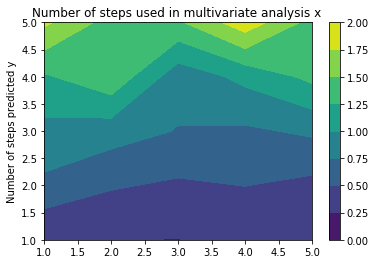

In [15]:
import matplotlib.pyplot as plt
# n_out_max=3
xlist = np.linspace(1, n_out_max, n_out_max)
ylist = np.linspace(1, n_out_max, n_out_max)
X, Y = np.meshgrid(xlist, ylist)
# Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, r)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Number of steps used in multivariate analysis x ')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('Number of steps predicted y')
plt.show()
